In [14]:
import keras
import numpy as np
from keras import backend as k
from keras import optimizers
from keras.layers import *
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import load_model
from keras.engine.topology import Layer
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import matplotlib.cm as cm

In [4]:
batchsize = 32
n_z = 20

This is the sample function needed to combine the encoder and decoder model.

Task: (20 points)

- Implement the reparameterziation trick for sampling latents. (10 points)
- Explain why we need to use this trick. (10 points)

In [ ]:
def sample_z(args):
    mu, log_sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps

**Explain why we need to use this trick:**

To train the model, we need the gradient of the sampling operation, but without the reparametrization trick, this samping operation is not differentiable. This trick takes the part that is not differentiable out of the network which enables us to train the network.

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
batches = int(len(x_train)/batchsize)

In [ ]:
image_size = x_train.shape[1]

In [ ]:
def batch_generator():
    
    while True:

        for batch in range(batches):
            x = []
            
            data = x_train[batch * batchsize: (batch + 1) * batchsize]
            for i in data:
                x.append(np.reshape(i, (28, 28, 1)))
            
            x_train1 = np.asarray(x)
            yield (x_train1, x_train1) # the data is also the target (since we're re-generating images)

This is the code for the encoder. It transforms observables (images) to latents (features). It corresponds to q(z | x) in the context of variational inference (and the slides), where z is latents and x is observables.

Task: (10 points)

- Implement the encoder class for a variational autoencoder. Note that the encoder should output the Gaussian distribution parameters (mean and variance per feature) of features rather than features themselves.

In [ ]:
inputs1 = Input(shape = (28, 28, 1))

encode = Conv2D(32, (2, 2), strides=2, padding = 'same')(inputs1)

encode = Activation('relu')(encode)

encode = Conv2D(32, (2, 2), strides=2, padding = 'same')(encode)

encode = Activation('relu')(encode)

out_shape = list(k.int_shape(encode))

encode = Flatten()(encode)

encode = Dense(420, activation = 'relu')(encode)

encode = Dropout(0.5)(encode)

mu = Dense(n_z, activation = 'linear')(encode)

log_sigma = Dense(n_z, activation = 'linear')(encode)

latent_vector = Lambda(sample_z, output_shape=(n_z,))([mu, log_sigma])

model_encoder = Model(inputs = inputs1, outputs = [mu, log_sigma, latent_vector])

In [ ]:
model_encoder.summary()

This is the code for the decoder. It transforms latents (features) to observables (images). It corresponds to p(x | z) in the context of variational inference (and the slides), where x is observables and z is latents.

Task: (10 points)

- Implement the decoder class for a variational autoencoder. Note that the decoder should output the Gaussian distribution parameters (mean and variance per pixel) of images rather than images themselves.

In [ ]:
inputs2 = Input(shape = (n_z,))

decode = Dense(out_shape[1] * out_shape[2] * out_shape[3], activation = 'relu')(inputs2)

decode = Reshape((out_shape[1], out_shape[2], out_shape[3]))(decode)

decode = Conv2DTranspose(32, (2, 2), strides=2, padding = 'same')(decode)

decode = Activation('relu')(decode)

decode = Conv2DTranspose(32, (2, 2), strides=2, padding = 'same')(decode)

decode = Activation('relu')(decode)

out = Conv2DTranspose(1, (2, 2), activation = 'sigmoid', padding = 'same')(decode)

model_decoder = Model(inputs = inputs2, outputs = out)

In [ ]:
model_decoder.summary()

In [ ]:
outputs = model_decoder(model_encoder(inputs1)[2])
model = Model(inputs1, outputs)

This is the loss class. The loss of encoder and decoder of a variational autoencoder is the evidence lower bound as follows:

$L = D_{KL}(q(z | x), p(z)) -  E_{z\sim q}[log p(x | z)]$

The first term above is the KL divergence between the approximate posterior (q) and the prior (p), which can be interpreted as a form of regularization. You can assume that the prior is unit Gaussian. It can be implemented with the F.gaussian_kl_divergence function in Chainer.

The second term above is the Gaussian negative log likelihood. This is the term that fits the data, which is very similar to the usual loss functions that you use in deep learning. It can be implemented with the F.gaussian_nll function in Chainer.

Task: 

- Implement the loss class. (10 points)
- Explain why we use log variance instead of variance. (5 points)



In [ ]:
def _loss(y_true, y_pred):
    reconstruction_loss = image_size * image_size * binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
    kl_loss = -0.5 * K.sum(1 + log_sigma - K.square(mu) - K.exp(log_sigma), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    
    return vae_loss

**Explain why we use log variance instead of variance:**

Why use log variance instead of variance: Because taking the exponent is numerically more stable than taking the log.


In [ ]:
adam_ = optimizers.Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [ ]:
model.compile(optimizer = adam_, loss = _loss)

In [ ]:
model.fit_generator(batch_generator(), steps_per_epoch = batches, epochs = 10, shuffle = True)

Task: (50 points)

- Train the above defined variational autoencoder on the Mnist dataset. You can refer to the earlier assignments to implement your training loop. (25 points)

- How good are the samples? Randomy sample some digits and visualize them. (10 points)

- How good are the reconstructions? Draw an Mnist like digit, encode it, decode it and visualize the digits. How different is the reconstruction from the original? (10 points)

- Repeat the last task but by drawing something other than a digit (e.g., a face). How accuracte is the reconstructions? Explain the results. (5 points)

** How good are the samples? Randomy sample some digits and visualize them. (10 points) **

As it can be seen the samples are good in a sense that you can recognize the digits displayed. However the overall quality of the samples can still be argued to be quite bad, since the images are very pixelated.

(60000, 28, 28)


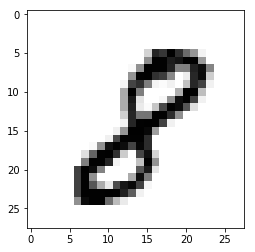

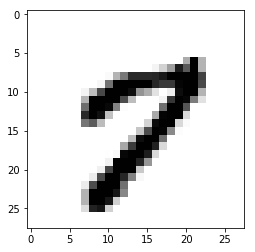

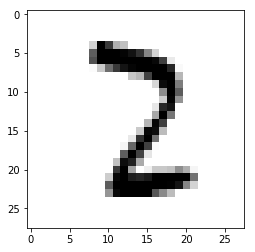

In [18]:
print(x_train.shape)

for i in range(0, 3):
    random_number = np.random.randint(0, x_train.shape[0])
    imshow(x_train[random_number, :, :], cmap=cm.binary)
    plt.show()